## Import Library

In [8]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
import random
import os
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

## Load Dataset

In [9]:
train_dir = Path("train")
test_dir = Path("test")
valid_dir = Path("valid")

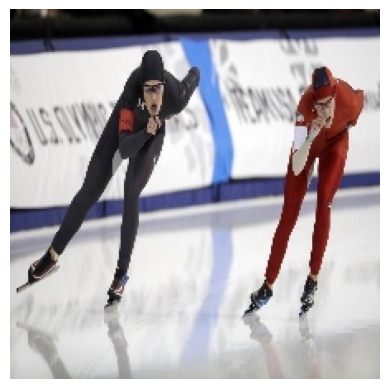

Displayed image from: train\speed skating\027.jpg


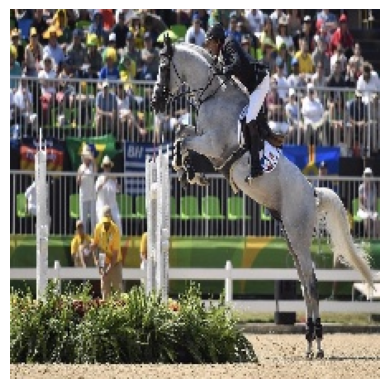

Displayed image from: test\horse jumping\3.jpg


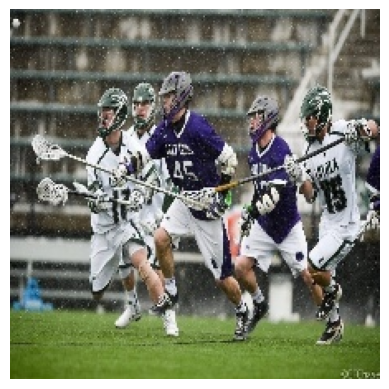

Displayed image from: valid\lacrosse\3.jpg


In [10]:
def display_random_image_from_folder(folder_path):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    random_subfolder = random.choice(subfolders)
    image_files = [f for f in os.listdir(random_subfolder) if os.path.isfile(os.path.join(random_subfolder, f))]

    random_image = random.choice(image_files)

    random_image_path = os.path.join(random_subfolder, random_image)


    img = Image.open(random_image_path)
    plt.imshow(img)
    plt.axis('off')  
    plt.show()
    print(f"Displayed image from: {random_image_path}")

display_random_image_from_folder(train_dir)

display_random_image_from_folder(test_dir)

display_random_image_from_folder(valid_dir)

In [11]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define constants
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 100
INITIAL_LEARNING_RATE = 0.001

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=42
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


## Create Custom CNN Model

In [12]:
# Build a more memory-efficient model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

In [13]:
# Compile the model
optimizer = Adam(learning_rate=INITIAL_LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('worst_model.keras', 
                             save_best_only=True, 
                             monitor='val_accuracy', 
                             mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


### Train and validation

In [14]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

Epoch 1/50


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


421/421 ━━━━━━━━━━━━━━━━━━━━ 881s 2s/step - accuracy: 0.0742 - loss: 4.7133 - val_accuracy: 0.0500 - val_loss: 5.4831 - learning_rate: 0.0010
Epoch 2/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - accuracy: 0.0625 - loss: 4.0601 - val_accuracy: 0.0000e+00 - val_loss: 6.1330 - learning_rate: 0.0010


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 3/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.1958 - loss: 3.4485 - val_accuracy: 0.1646 - val_loss: 4.1507 - learning_rate: 0.0010
Epoch 4/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2812 - loss: 3.2870 - val_accuracy: 0.2500 - val_loss: 4.0209 - learning_rate: 0.0010
Epoch 5/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.2653 - loss: 2.9443 - val_accuracy: 0.3812 - val_loss: 2.4509 - learning_rate: 0.0010
Epoch 6/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3750 - loss: 2.6162 - val_accuracy: 0.4000 - val_loss: 2.1047 - learning_rate: 0.0010
Epoch 7/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - accuracy: 0.3496 - loss: 2.5522 - val_accuracy: 0.3125 - val_loss: 3.0349 - learning_rate: 0.0010
Epoch 8/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 403us/step - accuracy: 0.3750 - loss: 2.5114 - val_accuracy: 0.2000 - val_loss: 2.9907 - learning_rate: 0.0010
Epoch 9/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.4057 - loss: 2.2

### Test Loss and Accuracy

In [15]:
# Load the best model
model.load_weights('worst_model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 411ms/step - accuracy: 0.6950 - loss: 1.0827
Test accuracy: 0.7140
Test loss: 1.0326


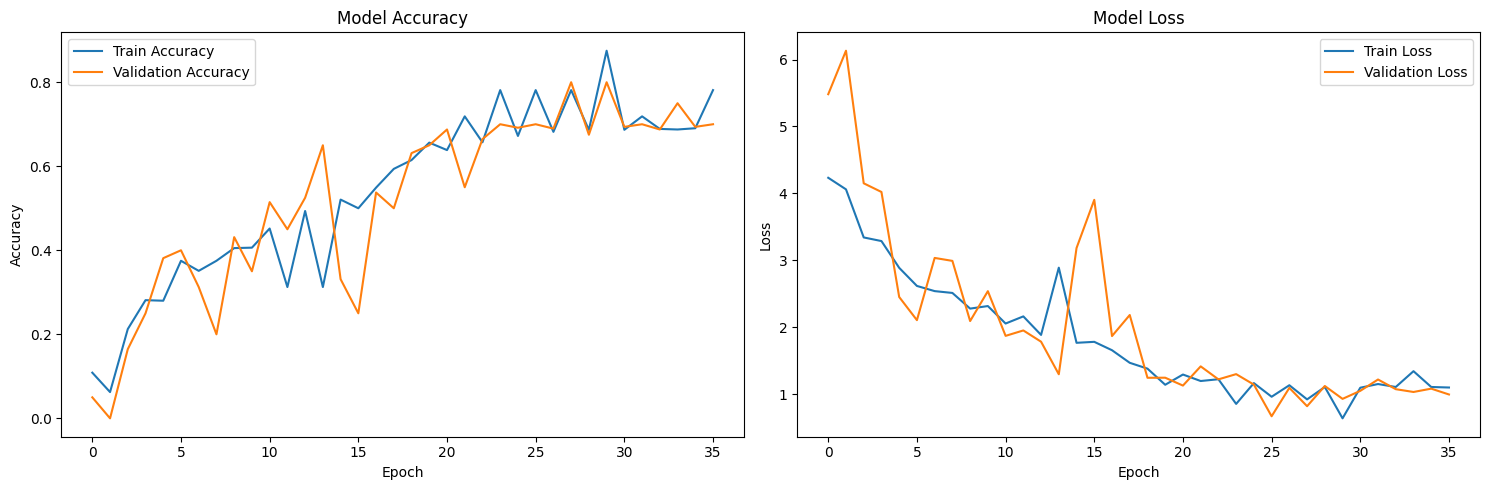

In [16]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

## Classification Report

In [17]:
# Generate predictions for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Generate classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("Classification Report:")
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step
Classification Report:
                       precision    recall  f1-score   support

           air hockey       0.83      1.00      0.91         5
      ampute football       1.00      0.40      0.57         5
              archery       0.50      0.40      0.44         5
        arm wrestling       1.00      0.60      0.75         5
         axe throwing       1.00      0.80      0.89         5
         balance beam       0.56      1.00      0.71         5
        barell racing       0.80      0.80      0.80         5
             baseball       0.60      0.60      0.60         5
           basketball       0.67      0.80      0.73         5
       baton twirling       0.50      0.20      0.29         5
            bike polo       1.00      0.60      0.75         5
            billiards       0.80      0.80      0.80         5
                  bmx       1.00      0.20      0.33         5
              bobsled       0.50      0.20      0.29 

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Performance analysis

In [18]:
def evaluate_model(model, generator, set_name):
    predictions = model.predict(generator)
    true_classes = generator.classes
    predicted_classes = np.argmax(predictions, axis=1)
    return true_classes, predicted_classes
    
test_true, test_pred = evaluate_model(model, test_generator, "Test")

# Calculate per-class accuracy
def per_class_accuracy(true_classes, predicted_classes, class_names):
    cm = confusion_matrix(true_classes, predicted_classes)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    return dict(zip(class_names, per_class_acc))

test_accuracy = per_class_accuracy(test_true, test_pred, class_names)

# Sort classes by accuracy
sorted_classes = sorted(test_accuracy.items(), key=lambda x: x[1])

# Identify underperforming classes
underperforming_threshold = 0.4
underperforming_classes = [class_name for class_name, acc in sorted_classes if acc < underperforming_threshold]
print("Number of Underperforming classes:", len(underperforming_classes))
print("Underperforming classes:", underperforming_classes)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step
Number of Underperforming classes: 12
Underperforming classes: ['cheerleading', 'roller derby', 'baton twirling', 'bmx', 'bobsled', 'frisbee', 'horseshoe pitching', 'hydroplane racing', 'sidecar racing', 'ski jumping', 'steer wrestling', 'ultimate']


Possible reasons for under performance:
   1. Class imbalance in the training data
   2. Visual similarity between classes (e.g., similar sports)
   3. Insufficient training examples for certain classes
   4. High intra-class variability (e.g., indoor vs. outdoor versions of the same sport)

In [19]:
def visualize_predictions(generator, true_classes, predicted_classes, class_names, num_images=5, correct=True):
    plt.figure(figsize=(15, 3*num_images))
    
    if correct:
        indices = np.where(true_classes == predicted_classes)[0]
    else:
        indices = np.where(true_classes != predicted_classes)[0]
    
    for i, idx in enumerate(np.random.choice(indices, num_images, replace=False)):
        img = generator[idx // generator.batch_size][0][idx % generator.batch_size]
        true_label = class_names[true_classes[idx]]
        pred_label = class_names[predicted_classes[idx]]
        
        plt.subplot(num_images, 1, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}, Predicted: {pred_label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


### Visualization of good test examples

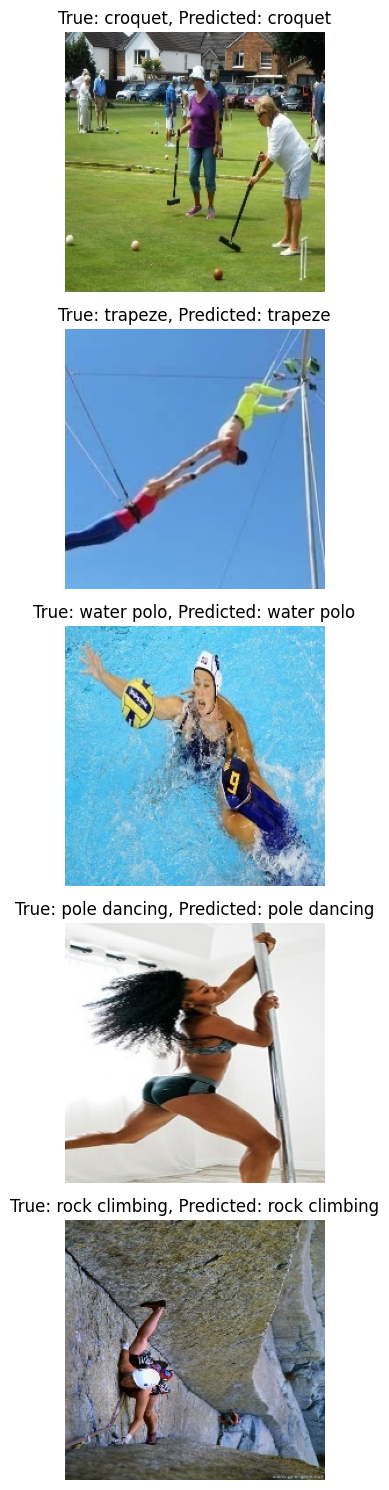

In [20]:
# Visualize correct predictions
visualize_predictions(test_generator, test_true, test_pred, class_names, num_images=5, correct=True)

### Visualization of bad test examples

Possible reasons for poor performance on certain examples:
   1.  Ambiguous images (e.g., sports with similar equipment)
   2.  Unusual angles or perspectives
   3.  Poor image quality or lighting conditions
4. Rare or underrepresented variations of a sport in the training data
5. Presence of multiple sports or activities in a single image

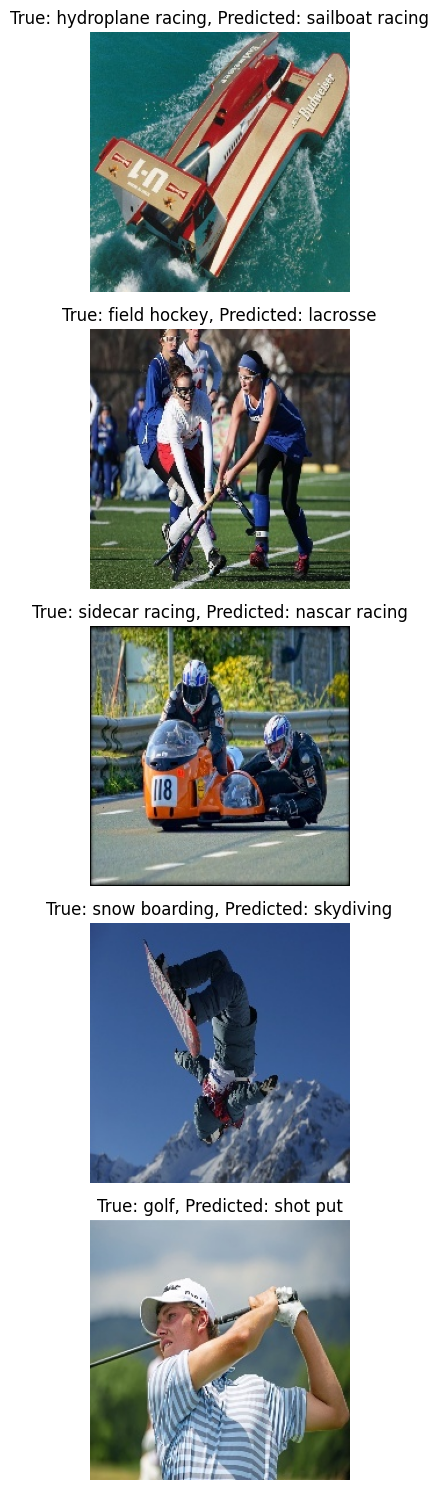

In [21]:
visualize_predictions(test_generator, test_true, test_pred, class_names, num_images=5, correct=False)

In [22]:
# Analyze common misclassifications
def analyze_misclassifications(true_classes, predicted_classes, class_names):
    cm = confusion_matrix(true_classes, predicted_classes)
    misclassifications = []
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                misclassifications.append((class_names[i], class_names[j], cm[i, j]))
    
    return sorted(misclassifications, key=lambda x: x[2], reverse=True)[:10]

top_misclassifications = analyze_misclassifications(test_true, test_pred, class_names)
print("Top 10 misclassifications:")
for true_class, pred_class, count in top_misclassifications:
    print(f"True: {true_class}, Predicted: {pred_class}, Count: {count}")

Top 10 misclassifications:
True: cheerleading, Predicted: lacrosse, Count: 3
True: roller derby, Predicted: rollerblade racing, Count: 3
True: ski jumping, Predicted: snow boarding, Count: 3
True: arm wrestling, Predicted: sumo wrestling, Count: 2
True: bobsled, Predicted: luge, Count: 2
True: football, Predicted: lacrosse, Count: 2
True: frisbee, Predicted: tennis, Count: 2
True: horseshoe pitching, Predicted: hammer throw, Count: 2
True: hydroplane racing, Predicted: sailboat racing, Count: 2
True: parallel bar, Predicted: uneven bars, Count: 2


To improve the model's performance, consider:
1. Addressing class imbalance through data augmentation or class weighting
2. Collecting more diverse training data for under performing classes
3. Using transfer learning with a pre-trained model on a large dataset like ImageNet
4. Using complex models like Resnet50, EfficientNetB0 etc